# How to create the Ingredient Graph

This notebook explains how to create an Ingredient Graph (IG) from several json input files.

### Importing several Python modules

For graph creation, we need the `NetworkX` package. For reading json files, we need the `json` package. For graph drawing, we need the `matplotlib` package. For setting the correct collation for sorting node identifiers, we need the `locale` package. 

After loading package the `networkx` package, we start creating the Ingredient Graph by creating an empty graph.

In [2]:
import sys
# !{sys.executable} -m pip install networkx > nul
# !{sys.executable} -m pip install matplotlib > nul
# !{sys.executable} -m pip install mlxtend
# !{sys.executable} -m pip install xlwt
# !{sys.executable} -m pip install openpyxl
import networkx as nx
G = nx.Graph()
import json
import matplotlib.pyplot as plt
import locale
locale.setlocale(locale.LC_ALL, 'de-DE.utf-8')
import matplotlib.pyplot as plt
import openpyxl
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

### Nodes and edges

By definition, a graph is a collection of *nodes* along with identified pairs of nodes that we call *edges* here. 

In NetworkX, nodes can
be any [hashable](https://docs.python.org/3/glossary.html#term-hashable) object e.g., a text string, an image, an XML object, another Graph, a customized node object, etc. We can add one node at a time, or add nodes from any [iterable](https://docs.python.org/3/glossary.html#term-iterable) container, such as a list.

For creating the ingredient nodes, we read the json file that holds the ingredient lists of the recipes we want to combine into an Ingredient Graph. We start with an simplified file that holds only a single ingredient list.

### Read an ingredient list from a json file
Format of the json file by example:

In [3]:
{
  "recipeName": "ck-0113-Kürbissuppe mit Maronen und Speck",
  "ingredients": [
      "kürbis",
      "schalotten",
      "kartoffel",
      "marone",
      "gemüsebrühe",
      "crème_fraîche",
      "speck",
      "muskat",
      "petersilie",
      "olivenöl"
  ]
}

{'recipeName': 'ck-0113-Kürbissuppe mit Maronen und Speck',
 'ingredients': ['kürbis',
  'schalotten',
  'kartoffel',
  'marone',
  'gemüsebrühe',
  'crème_fraîche',
  'speck',
  'muskat',
  'petersilie',
  'olivenöl']}

Now, let's read the related file from disk.

In [4]:
with open('test_file.json', encoding='utf-8') as file:
    data = json.load(file)
ingredients = data['ingredients']
ingredients.sort(key=locale.strxfrm)
#print (ingredients)

We sorted the ingredient names in order to provide edge names that carry the "smaller" ingredient name first. (Remember that edge names are a combination of two ingredient names.)

Now we build a complete graph `H` for this ingredient list. `H` stands for "Helper".

In [5]:
H = nx.complete_graph(ingredients)
#nx.set_edge_attributes(H, values = 1, name = 'weight')
#list(H.edges(data = True))

Just check graph `H` by looking at its the graphical representation.

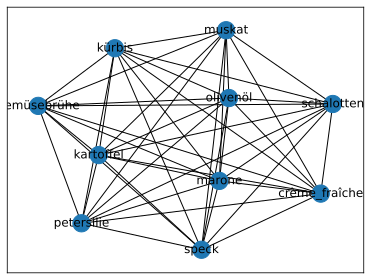

In [6]:
#pos=nx.spring_layout(H) # pos = nx.nx_agraph.graphviz_layout(H)
nx.draw_networkx(H)
#weights = nx.get_edge_attributes(H,'weight')
#nx.draw_networkx_edge_labels(H,pos,edge_labels=weights)
plt.show()

Now, we unite graphs `G` and `H`. For this purpose, we define a function `cap_union` that has two parameters, graph `L` ("Left") and graph `R` ("Right"). `L` holds the graph after union with `R`.

Aside: We make a distinction between three different union functions:
* dis_union: stands for disjoint union
* top_union: stands for topological union, i.e. multiedges resulting from the union are silently collapsed into a single edge.
* mul_union: stands for union with resulting multiedges
* cap_union: stands for capacity union, i.e. multiedges resulting from the union are coerced into a single edge, their weights are initialized to 1 (if required) and added, and the sum of weights is assigned to the remaining single edge.

(Separate notebook under preparation.)

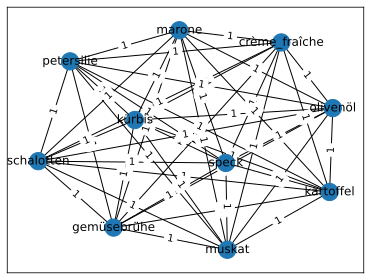

In [7]:
G.clear()
# capacity union function
def cap_union(L,R):
    for u,v,data in R.edges(data=True):
        w = data['weight'] if 'weight' in data else 1
        if L.has_edge(u,v):
            L[u][v]['weight'] += w     
        else:
            L.add_edge(u, v, weight=w)
cap_union(G,H)
pos=nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G,pos)
weights = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=weights)
plt.show()
G.clear()

`G` now contains the nodes and edges of `H` as nodes and edges of `G`. Every edge has a `weight` data element.

Next step:

Generating complete helper graphs from input ingredient lists and uniting them with `G` will finally result in a graph `G` that holds all topological information of the final Ingredient Graph plus edge `weight` data.

To give an example, we extend the above procedure by wrapping it into a loop for all recipe ingredient lists that are given in the json file `five_recipes.json`.

269.0
222
32


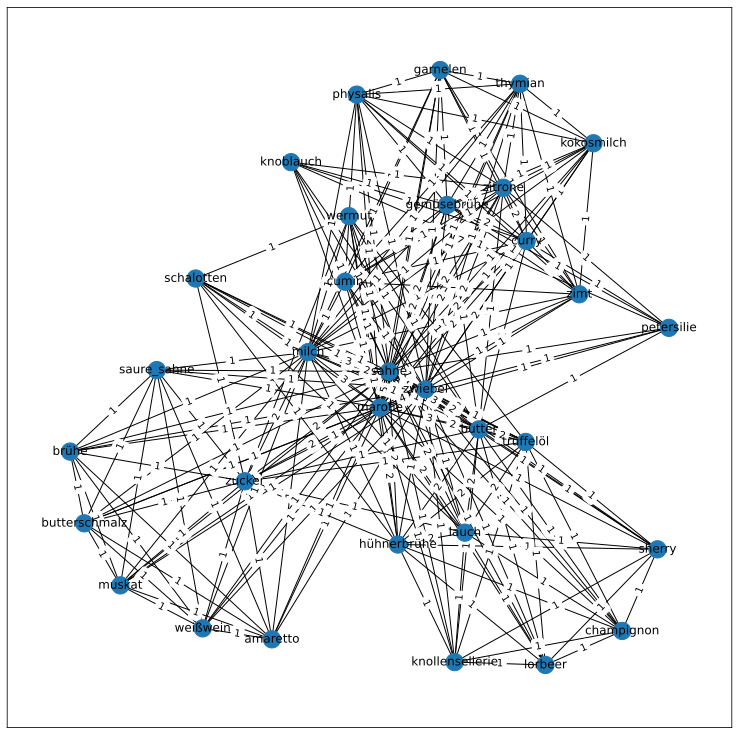

In [8]:
with open('five_recipes.json', encoding='utf-8') as file:
    data = json.load(file)
G.clear()
for rcp in data:
    ingredients = rcp["ingredients"]
    ingredients.sort(key=locale.strxfrm)
    #print (ingredients)
    H.clear()
    H = nx.complete_graph(ingredients)
    #nx.set_edge_attributes(H, values = 1, name = 'weight')
    cap_union(G,H)
#print(G.nodes(data=True))
#print(G.edges(data=True))
print(G.size(weight="weight"))
print(G.number_of_edges())
print(nx.number_of_nodes(G))
plt.rcParams['figure.figsize'] = [13, 13]
pos=nx.spring_layout(G, k=1) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G,pos)
weights = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=weights)
plt.savefig("Five_rcp.svg", format="svg")
plt.show()

The resulting graph has 33 nodes, 227 distinct edges, and the sum of edge weights is 269.

### Generate data structure for node-related `i-name`, `i-class` and `i-occ` data elements
Idea: dict of dicts.

Example given below together with access code.

In [9]:
sample_igt = {
    'sahne': {'i-name': 'Sahne', 'i-class' : 'fat',  'i-occ' : 4},
    'brühe': {'i-name': 'Brühe', 'i-class' : 'fat',  'i-occ' : 4},
    'quark': {'i-name': 'Quark', 'i-class' : 'milk', 'i-occ' : 6}
}
igt_sorted = dict(sorted(sample_igt.items(),key=lambda ingredient : locale.strxfrm(ingredient[0])))
print (igt_sorted)

# Find below sample code for accessing the dict-of-dict data structure that is used for ingredient attributes

#print (sample_igt)
#for igt in sample_igt.keys():
#    print (igt)
#for igt in sample_igt.values():
#    print (igt)
#x = 'sahne'
#print (sample_igt.get(x).get('i-class'))
#if 'sahne' in sample_igt:
#    print (sample_igt.get('sahne'))

{'brühe': {'i-name': 'Brühe', 'i-class': 'fat', 'i-occ': 4}, 'quark': {'i-name': 'Quark', 'i-class': 'milk', 'i-occ': 6}, 'sahne': {'i-name': 'Sahne', 'i-class': 'fat', 'i-occ': 4}}


### Assign an `i-name` data element to the nodes of the Ingredient Graph
Get the required information from the ingredient catalogue `igt_cat.json`.

In the first step, we read this file. 

In [10]:
with open('igt_cat.json', encoding='utf-8') as file:
    cat_data = json.load(file)
#print (cat_data)

Let's compose a list for setting the node attribute `i-name`, and then add the `i-name`data element to the graph nodes.

In [11]:
i_names = {igt:cat_data[igt]['i-name'] for igt in G.nodes}
nx.set_node_attributes(G, i_names,name='i-name')
#print(i_names)
#print (G.nodes(data=True))

### Assign an `i-class` data element to the nodes of the Ingredient Graph
In the final Ingredient Graph, every ingredient is assigned to an ingredient class ("class" for short). The class information is contained in another json file, namely `igt_cat.json`.

* read ingredient catalogue
* per node: extract class value from ingredient catalogue and assign to node

In [12]:
i_classes = {igt:cat_data[igt]['i-class'] for igt in G.nodes}
nx.set_node_attributes(G, i_classes,name='i-class')
#print(i_classes)
#print (G.nodes(data=True))

### Assign an `i-occ` data element to the nodes of the Ingredient Graph
`i-occ` counts the number of occurrences of the respective ingredient in the recipe collection.

Nested loop:

    iterate over recipes  
        iterate over ingredient lists

In [13]:
list_of_ingredients = []
for rcp in data:
    for ingredient in rcp['ingredients']:
        list_of_ingredients.append(ingredient)
#print (list_of_ingredients)
occurences = {igt:list_of_ingredients.count(igt) for igt in list_of_ingredients}
occ_sorted = dict(sorted(occurences.items(),key=lambda igt : locale.strxfrm(igt[0])))
#print(occ_sorted)
nx.set_node_attributes(G, occ_sorted, name='i-occ')
print(G.nodes(data=True))
#print(nx.number_of_nodes(G))
#print(G.nodes.get('sahne')) # sample code

[('cumin', {'i-name': 'Cumin', 'i-class': 'spice', 'i-occ': 1}), ('curry', {'i-name': 'Curry', 'i-class': 'spice', 'i-occ': 2}), ('garnelen', {'i-name': 'Garnelen', 'i-class': 'fish', 'i-occ': 1}), ('gemüsebrühe', {'i-name': 'Gemüsebrühe', 'i-class': 'condi', 'i-occ': 2}), ('kokosmilch', {'i-name': 'Kokosmilch', 'i-class': 'fat', 'i-occ': 1}), ('marone', {'i-name': 'Marone', 'i-class': 'nuts', 'i-occ': 5}), ('milch', {'i-name': 'Milch', 'i-class': 'milk', 'i-occ': 3}), ('physalis', {'i-name': 'Physalis', 'i-class': 'fruit', 'i-occ': 1}), ('sahne', {'i-name': 'Sahne', 'i-class': 'milk', 'i-occ': 5}), ('thymian', {'i-name': 'Thymian', 'i-class': 'herb', 'i-occ': 1}), ('zimt', {'i-name': 'Zimt', 'i-class': 'spice', 'i-occ': 1}), ('zitrone', {'i-name': 'Zitrone', 'i-class': 'fruit', 'i-occ': 2}), ('zwiebel', {'i-name': 'Zwiebel', 'i-class': 'onion', 'i-occ': 4}), ('butter', {'i-name': 'Butter', 'i-class': 'fat', 'i-occ': 3}), ('knoblauch', {'i-name': 'Knoblauch', 'i-class': 'onion', 'i-occ

['cumin', 'curry', 'garnelen', 'gemüsebrühe', 'kokosmilch', 'marone', 'milch', 'physalis', 'sahne', 'thymian', 'zimt', 'zitrone', 'zwiebel', 'butter', 'knoblauch', 'petersilie', 'hühnerbrühe', 'lauch', 'schalotten', 'trüffelöl', 'wermut', 'zucker', 'champignon', 'knollensellerie', 'lorbeer', 'sherry', 'amaretto', 'brühe', 'butterschmalz', 'muskat', 'saure_sahne', 'weißwein']


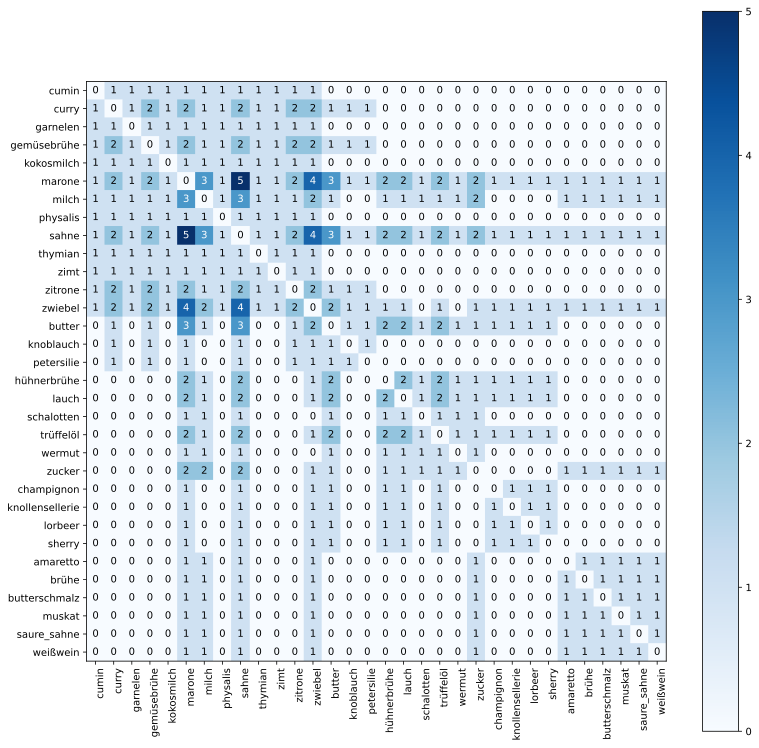

In [27]:
import numpy as np
from mlxtend.plotting import heatmap
dtype = np.dtype([("weight", int)])
A = nx.to_numpy_array(G, dtype=dtype, weight=None)
#with np.printoptions(edgeitems=50):
#    print(A["weight"])
rn = G.nodes
print (rn)
heatmap(A["weight"], figsize=(13, 13), cell_fmt='d',cmap='Blues',row_names=rn,column_names=rn,column_name_rotation=90)
plt.show()

In [15]:
ap_arr = []
for rcp in data:
    row = rcp["ingredients"]
    ap_arr.append(row)
print (ap_arr)

[['cumin', 'curry', 'garnelen', 'gemüsebrühe', 'kokosmilch', 'marone', 'milch', 'physalis', 'sahne', 'thymian', 'zimt', 'zitrone', 'zwiebel'], ['butter', 'curry', 'gemüsebrühe', 'knoblauch', 'marone', 'petersilie', 'sahne', 'zitrone', 'zwiebel'], ['butter', 'hühnerbrühe', 'lauch', 'marone', 'milch', 'sahne', 'schalotten', 'trüffelöl', 'wermut', 'zucker'], ['butter', 'champignon', 'hühnerbrühe', 'knollensellerie', 'lauch', 'lorbeer', 'marone', 'sahne', 'sherry', 'trüffelöl', 'zwiebel'], ['amaretto', 'brühe', 'butterschmalz', 'marone', 'milch', 'muskat', 'sahne', 'saure_sahne', 'weißwein', 'zucker', 'zwiebel']]


In [16]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(ap_arr).transform(ap_arr)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,amaretto,brühe,butter,butterschmalz,champignon,cumin,curry,garnelen,gemüsebrühe,hühnerbrühe,...,schalotten,sherry,thymian,trüffelöl,weißwein,wermut,zimt,zitrone,zucker,zwiebel
0,False,False,False,False,False,True,True,True,True,False,...,False,False,True,False,False,False,True,True,False,True
1,False,False,True,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,True
2,False,False,True,False,False,False,False,False,False,True,...,True,False,False,True,False,True,False,False,True,False
3,False,False,True,False,True,False,False,False,False,True,...,False,True,False,True,False,False,False,False,False,True
4,True,True,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,True


In [17]:
from mlxtend.frequent_patterns import apriori
apriori(df, min_support=0.6, use_colnames=True)

,support,itemsets
0,0.6,(butter)
1,1.0,(marone)
2,0.6,(milch)
3,1.0,(sahne)
4,0.8,(zwiebel)
5,0.6,"(marone, butter)"
6,0.6,"(sahne, butter)"
7,0.6,"(milch, marone)"
8,1.0,"(sahne, marone)"
9,0.8,"(marone, zwiebel)"


In [18]:
frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.6,(butter),1
1,1.0,(marone),1
2,0.6,(milch),1
3,1.0,(sahne),1
4,0.8,(zwiebel),1
5,0.6,"(marone, butter)",2
6,0.6,"(sahne, butter)",2
7,0.6,"(milch, marone)",2
8,1.0,"(sahne, marone)",2
9,0.8,"(marone, zwiebel)",2


In [19]:
frequent_itemsets[ (frequent_itemsets['length'] >= 2) &
                   (frequent_itemsets['support'] >= 0.6) ]

,support,itemsets,length
5,0.6,"(marone, butter)",2
6,0.6,"(sahne, butter)",2
7,0.6,"(milch, marone)",2
8,1.0,"(sahne, marone)",2
9,0.8,"(marone, zwiebel)",2
10,0.6,"(milch, sahne)",2
11,0.8,"(sahne, zwiebel)",2
12,0.6,"(sahne, marone, butter)",3
13,0.6,"(milch, marone, sahne)",3
14,0.8,"(sahne, marone, zwiebel)",3


In [20]:
from mlxtend.frequent_patterns import association_rules
association_rules(frequent_itemsets, metric="lift", min_threshold=0.7)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(marone),(butter),1.0,0.6,0.6,0.6,1.0,0.0,1.0
1,(butter),(marone),0.6,1.0,0.6,1.0,1.0,0.0,inf
2,(sahne),(butter),1.0,0.6,0.6,0.6,1.0,0.0,1.0
3,(butter),(sahne),0.6,1.0,0.6,1.0,1.0,0.0,inf
4,(milch),(marone),0.6,1.0,0.6,1.0,1.0,0.0,inf
5,(marone),(milch),1.0,0.6,0.6,0.6,1.0,0.0,1.0
6,(sahne),(marone),1.0,1.0,1.0,1.0,1.0,0.0,inf
7,(marone),(sahne),1.0,1.0,1.0,1.0,1.0,0.0,inf
8,(marone),(zwiebel),1.0,0.8,0.8,0.8,1.0,0.0,1.0
9,(zwiebel),(marone),0.8,1.0,0.8,1.0,1.0,0.0,inf


In [21]:
with open('flavour_recipes.json', encoding='utf-8') as file:
    data = json.load(file)
flv_arr = []
for rcp in data:
    row = rcp["ingredients"]
    flv_arr.append(row)
#print (flv_arr)

In [22]:
te_ary = te.fit(flv_arr).transform(flv_arr)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,ahornsirup,ancho,apfel,apfelessig,aprikose,auberginen,austernpilz,avocado,babyspinat,balsamico,...,weißweinessig,worcester,zatar,ziegenfrischkäse,zimt,zitrone,zucchini,zucker,zuckerschoten,zwiebel
0,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,True,True,False,False,False,True
4,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
88,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
89,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
90,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False


In [23]:
frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets
frequent_itemsets.to_excel('flv_fp.xlsx')

In [24]:
with open('HDGem_recipes.json', encoding='utf-8') as file:
    data = json.load(file)
hdg_arr = []
for rcp in data:
    row = rcp["ingredients"]
    hdg_arr.append(row)
te_ary = te.fit(hdg_arr).transform(hdg_arr)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,ackerbohne,ackerrettich,apfel,artischocken,austern,beeren,birne,blumenkohl,bratenjus,bratfett,...,weiße_bohnen,weißkohl,wirsing,wurzeln,zimt,zitrone,zucker,zuckerschoten,zwieback,zwiebel
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
91,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
92,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
93,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets
frequent_itemsets.to_excel('hdg_fp.xlsx')